# How to use Google calendar API?

How to import Google calendar API?


In [ ]:
var execSync = require('child_process').execSync;
try {
    require.resolve('googleapis');
    require.resolve('google-auth-library');
} catch (e) {
    execSync('npm install googleapis google-auth-library');
}
var google = require('googleapis');
var googleAuth = require('google-auth-library');

var importer = require('../Core');
var seleniumPath = __dirname + '/../Selenium/google authorize.ipynb';

// Authorize a client with the loaded credentials, then call the
  // Google Calendar API.
var oauth2Client;
var getOauthClient = (options = {}) => {
    return importer.importNotebook(seleniumPath)
    .then(r => r.authorize(['https://www.googleapis.com/auth/calendar']))
    .then(c => {
        var auth = new googleAuth();
        oauth2Client = new auth.OAuth2(
            c.clientId_, c.clientSecret_, c.redirectUri_);
        oauth2Client.credentials = c.credentials;
        return oauth2Client;
    })
    .then(auth => (options.auth = auth))
};
module.exports = getOauthClient;
getOauthClient;



How to list events?

In [ ]:
var importer = require('../Core');
var google = require('googleapis');

var calendar = google.calendar('v3');

var processResult = (err, response, options) => {
    if (err) {
      console.log('The API returned an error: ' + err);
      throw err;
    }
    resultEvents = []; // reset the array
    var events = response.items;
    if (events.length == 0) {
        console.log('No events found for ' + JSON.stringify(options));
    } else {
        for (var i = 0; i < events.length; i++) {
            var event = events[i];
            var start = event.start.dateTime || event.start.date;
            resultEvents[resultEvents.length] = {
                start: new Date(start), event: event};
        }
    }
    return resultEvents;
};


/**
 * Lists the next 10 events on the user's primary calendar.
 *
 * @param {google.auth.OAuth2} auth An authorized OAuth2 client.
 */
var resultEvents = [];
var getOauthClient, correctTimeLimits, correctCalendarId;
var listEvents = (options = {calendarId: 'primary'}) => {
    return importer.interpretAll([
        'import google calendar api',
        'correct dates time',
        'lookup calendar name'
    ])
    .then(r => {
        getOauthClient = r[0].runInNewContext();
        correctTimeLimits = r[1].runInNewContext();
        correctCalendarId = r[2].runInNewContext();
        if(typeof options.auth === 'undefined') {
            return getOauthClient(options);
        }
    })
    .then(() => correctTimeLimits(options))
    .then(() => correctCalendarId(options))
    .then(() => {
        if(typeof options['calendarId'] == 'undefined') {
            options['calendarId'] = 'primary';
        }
        var data = Object.assign({}, options, {
            maxResults: 100,
            singleEvents: true,
            orderBy: 'startTime'
        });
        return new Promise((resolve, reject) => {
            calendar.events.list(data, (err, response) => {
                if(err) reject(err);
                try {
                    var events = processResult(err, response, options);
                    resolve(events);
                } catch (e) {
                    reject(e);
                }
            });
        });
    });
};
module.exports = listEvents;
listEvents;



Run todays calendar events?



In [ ]:
var importer = require('../Core');
var google = require('googleapis');
var calendar = google.calendar('v3');

var getOauthClient, listEvents, correctCalendarId;
// test Google calendar API?
var runTodaysEvents = () => {
    var options = {}, commands = [];
    var eventId, isError;
    return importer.interpretAll([
        'list events',
        'import google calendar api',
        'lookup calendar name'
    ])
    .then(r => {
        listEvents = r[0].runInNewContext();
        getOauthClient = r[1].runInNewContext();
        correctCalendarId = r[2].runInNewContext();
        return getOauthClient(options);
    })
    .then(() => correctCalendarId(Object.assign(options, {
        calendarId: 'commands'
    })))
    .then(() => listEvents({
        auth: options.auth,
        calendarId: options.calendarId,
        timeMin: 'yesterday',
        timeMax: 'tomorrow',
    }))
    .then(events => {
        var names = events.map(e => e.event.summary);
        // filter processed
        commands = events
        .filter(e => e.event.summary.indexOf('Result:') == -1
                && names.indexOf('Result: ' + e.event.summary) == -1)
        
        // TODO: change this slice
        .slice(0, 1);
        if(commands.length == 0) throw new Error('No events!');
    })
    // create a new events to store the results
    .then(() => new Promise((resolve, reject) => {
        isError = false;
        calendar.events.insert(Object.assign({}, {
            calendarId: options.calendarId,
            auth: options.auth,
            resource: {
                start: commands[0].event.start,
                end: commands[0].event.end,
                summary: 'Result: ' + commands[0].event.summary,
                description: 'starting',
                colorId: 9
            }
        }), (err, response) => {
            if(err) reject(err);
            try {
                resolve(response);
            } catch (e) {
                reject(e);
            }
        });
    }))
    .then(event => (eventId = event.id))
    // process the command
    .then(() => importer.interpretAll(commands[0].event.summary))
    // TODO: add parameter input from event content
    // TODO: check for retry count from event content
    // TODO: add time limits for successful commands
    .then(r => r.runInNewContext()())
    .catch(e => {
        isError = true;
        return Object.getOwnPropertyNames(e).reduce((alt, key) => {
            alt[key] = e[key];
            return alt;
        }, {})
    })
    // update the calendar event with the results
    .then(r => new Promise((resolve, reject) => {
        if(typeof eventId == 'undefined') {
            return resolve(r);
        }
        calendar.events.patch({
            eventId: eventId,
            calendarId: options.calendarId,
            auth: options.auth,
            resource: {
                description: JSON.stringify(r, null, 4),
                colorId: isError ? 11 : 10
            }
        }, (err, response) => {
            if(err) reject(err);
            try {
                resolve(response);
            } catch (e) {
                reject(e);
            }
        });
    }))
};
module.exports = runTodaysEvents;
runTodaysEvents;

// echo "require('/Users/briancullinan/jupytangular2/Core').interpretAll('run todays calendar events').then(r=>r.runInNewContext()()).then(e=>{ console.log(e); process.exit(e); }).catch(e=>{console.log(e); process.exit(e) });" | node

// echo "require('/Users/briancullinan/jupytangular2/Core').interpretAll('scrape facebook events').then(r=>r.runInNewContext()()).then(e=>{console.log(e); process.exit(e) }).catch(e=>{console.log(e); process.exit(e) });" | node


test calendar api graph Iga's cycle for as long as there are valid dates



In [ ]:
var importer = require('../Core');

$$.async();
var filterDistant, getOauthClient, listEvents, graphDates;
importer.interpretAll([
    'import google calendar api',
    'how to list events',
    'number of days between events',
    'display recurrence line graph'
])
.then(r => {
    getOauthClient = r[0].runInNewContext();
    listEvents = r[1].runInNewContext({getOauthClient});
    filterDistant = r[2].runInNewContext();
    graphDates = r[3].runInNewContext();
})
.then(() => listEvents({
    q: 'period',
    calendarId: 'p4685f6at8ccctenocjlqgnqss@group.calendar.google.com'
}))
.then(r => {
    $$.svg(graphDates(filterDistant(r)))
})
.catch(e => $$.sendError(e));




test calendar sum all hours worked on study sauce since september 2016



In [ ]:
var importer = require('../Core');

$$.async();
var sumEvents, getOauthClient, listEvents, ISODateString;
importer.interpretAll([
    'import google calendar api',
    'how to list events',
    'sum a list of events',
    'convert date to ISO'
])
.then(r => {
    getOauthClient = r[0].runInNewContext();
    listEvents = r[1].runInNewContext({getOauthClient});
    sumEvents = r[2].runInNewContext();
    ISODateString = r[3].runInNewContext();
})
.then(() => listEvents({
    timeMin: ISODateString(new Date('2016/09/22')),
    timeMax: ISODateString(new Date('2017/09/22')),
    q: 'study sauce'
}))
.then(r => {
    console.log(r);
    $$.sendResult(sumEvents(r))
})
.catch(e => $$.sendError(e));



Correct calendar dates for timeMax and timeMin?


In [ ]:
var importer = require('../Core');
var chrono = require('chrono-node');

var ISODateString;
var correctTimeLimits = (options) => {
    return importer.interpretAll([
        'convert date to ISO'
    ])
    .then(r => {
        ISODateString = r[0].runInNewContext();
        if(typeof options.timeMin !== 'undefined') {
            options.timeMin = ISODateString(
                chrono.parseDate(options.timeMin));
        }
        if(typeof options.timeMax !== 'undefined') {
            options.timeMax = ISODateString(
                chrono.parseDate(options.timeMax));
        }
        return options;
    });
};
module.exports = correctTimeLimits;
correctTimeLimits;



Lookup calendar id by name or id?



In [ ]:
var google = require('googleapis');
var calendar = google.calendar('v3');

var correctCalendarId = (options) => {
    if(typeof options.calendarId == 'undefined') {
        return Promise.resolve(Object.assign(options, {
            calendarId: 'primary'
        }))
    }
    return new Promise((resolve, reject) => {
        calendar.calendarList.list({
            auth: options.auth,
        }, (err, response) => {
            if(err) reject(e);
            try {
                resolve(response);
            } catch (e) {
                reject(e);
            }
        });
    })
    .then(r => {
        console.log(r);
        var rexexp = new RegExp(options.calendarId, 'ig');
        var matches = r.items.filter(c => c.id == options.calendarId);
        if(matches.length == 0) {
            matches = r.items.filter(c => c.summary.match(rexexp));
        }
        console.log('Using calendar: ' + matches[0].summary
                    + ' - ' + matches[0].id);
        options.calendarId = matches[0].id;
        return options;
    })
    .catch(e => console.log(e))
};
module.exports = correctCalendarId;
correctCalendarId;



In [3]:
var importer = require('../Core');
var interpretAllPath = path.join(__dirname, '../Core/interpret all notebooks.ipynb');

var queries = 'scrape facebook events';

$$.async();
importer.importNotebook(interpretAllPath)
.then((f) => {
    interpret = f['interpret'];
    interpretObject = f['interpretObject'];
})
// use Promise.all to do all of your code searches up front
.then(r => typeof queries == 'string' 
      ? interpret(queries) 
      : Promise.all(queries.map(interpret)))
//.then(r => typeof queries == 'string' 
//      ? interpretObject([r[0]])
//      : interpretObject(r.map(r => r[0])))
.then(r => $$.sendResult(r))
.catch(e => $$.sendError(e))


Already imported
[ 'import notebook.ipynb', 'interpret all notebooks.ipynb' ]


[ 'facebook data.ipynb[6]',
  'facebook data.ipynb[2]',
  'facebook data.ipynb[7]',
  'facebook data.ipynb[4]',
  'facebook data.ipynb[1]',
  'google calendar.ipynb[2]',
  'linkedin messages.ipynb[1]',
  'linkedin messages.ipynb[4]',
  'levenshtein.ipynb[1]',
  'Angular components.ipynb[1]',
  'interpret questions.ipynb[1]' ]

Show a d3 pie chart of time spent on projects?



Already imported
[ 'import notebook.ipynb',
  'interpret all notebooks.ipynb',
  'google authorize.ipynb' ]
Already imported
[ 'import notebook.ipynb',
  'interpret all notebooks.ipynb',
  'google authorize.ipynb' ]
study sauce
[ 'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Promote Study Sauce manually?',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study sauce',
  'Create robot out of study sauce validation',
  'Work on Study sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on study sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Stu

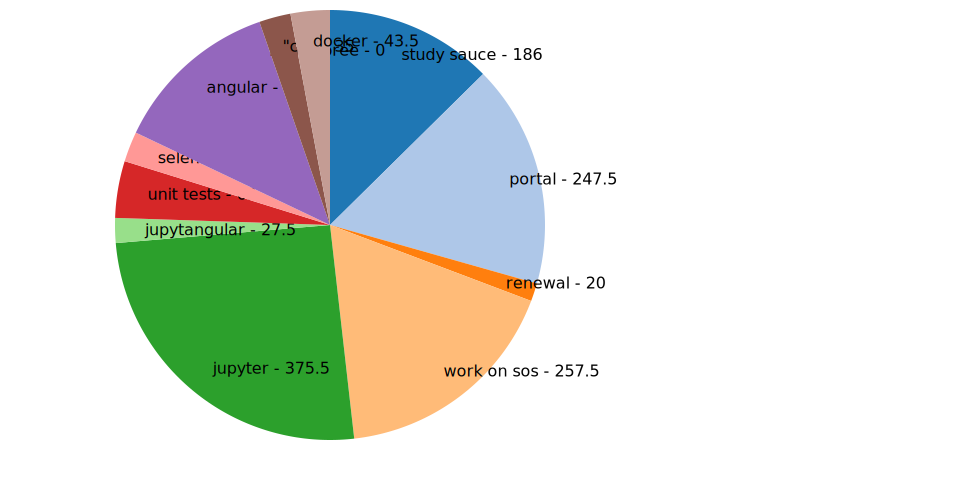

In [1]:
var importer = require('../Core');

var options = {};
var listEvents, getOauthClient, sumEvents, d3PieChart;

var calendarSearchToPieChart = (searches) => {
    return importer.interpretAll([
        'list events',
        'import google calendar api',
        'sum a list of events',
        'd3 pie chart'
    ])
    .then(r => {
        listEvents = r[0].runInNewContext();
        getOauthClient = r[1].runInNewContext();
        sumEvents = r[2].runInNewContext();
        d3PieChart = r[3].runInNewContext();
        return getOauthClient(options);
    })
    .then(() => {
        return importer.runAllPromises(searches
        .map(s => (resolve) => listEvents({
            auth: options.auth,
            q: s
        })
        .then(r => {
            console.log(s);
            console.log(r.map(e => e.event.summary));
            resolve({label: s, value: sumEvents(r)})
        })
        .catch(e => console.log(e))))
    })
    .then(r => d3PieChart(r))
    .catch(e => console.log(e))
}

$$.async();
calendarSearchToPieChart([
    'study sauce',
    'portal',
    'renewal',
    'work on sos',
    'jupyter',
    'jupytangular',
    'unit tests',
    'selenium',
    'angular',
    'mind spree',
    '"c#"',
    'docker'
])
.then(r => $$.svg(r))
.catch(e => $$.sendError(e))



In [7]:
var { JSDOM, XPathResult } = require("jsdom");
var fs = require('fs');
var chrono = require('chrono-node');
var importer = require('../Core');
var google = require('googleapis');
var calendar = google.calendar('v3');

var regexToArray = (ex, str, i = 0) => {
    var co = []; var m;
    while ((m = ex.exec(str)) && co.push(m[i]));
    return co;
};

// parse bookmark html
var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
// TODO: search using glob but include same list of excludes, how to abstract?
var bookmarks = fs.readFileSync(PROFILE_PATH + '/Documents/bookmarks_9_27_17_2.html').toString();
var dom = new JSDOM(bookmarks);

var parseBookmarks = () => {
    return getAllXPath([
        '//dt[./h3]',
        {
            title: './h3/text()',
            links: [
                './dl/dt/a',
                {
                    url: './@href',
                    time: './@add_date',
                    title: './@text()'
                }
            ],
            children: ['./dl/dt/h3/text()']
        }
    ], dom.window.document)
    .then(events => [].concat(...events.map(e => e.links.map(l => Object.assign(l, {folder: e.title})))))
    .then(events => {
        return events.map(e => Object.assign(e, {
            url: e.url+'',
            title: e.title+'',
            time_usec: parseFloat(e.time+'') * 1000,
        }))
        .reduce((links, event) => {
            // group by nearest half-hour and max out at 10 links
            var timeGroup = Math.round(event.time_usec / 60 / 30 / 1000) * 60 * 30 * 1000;
            if(typeof links[timeGroup] == 'undefined') {
                links[timeGroup] = [];
            }
            links[timeGroup].push(event)
            return links;
        }, {})
    });
};

$$.async();
var getOauthClient, getAllXPath, ISODateString, options = {};
importer.interpretAll([
    'import google calendar api',
    'all xpath elements',
    'date iso'
])
.then(r => {
    getOauthClient = r[0].runInNewContext();
    getAllXPath = r[1].runInNewContext({
        client: {
            execute: (func, ...args) => Promise.resolve({value: func.apply(dom.window.document, args)}),
            addCommand: () => {}
        },
        document: dom.window.document,
        XPathResult: {ORDERED_NODE_ITERATOR_TYPE: 5}
    });
    ISODateString = r[2].runInNewContext();
    return getOauthClient(options);
})
.then(() => parseBookmarks())
.then(links => {
    return Object.keys(links).map(t => ({
        start: {
            dateTime: ISODateString(new Date(parseInt(t)))
        },
        end: {
            dateTime: ISODateString(new Date(parseInt(t) + 60 * 30 * 1000)),
        },
        summary: links[t].map(l => l.folder).filter((l, i, a) => a.indexOf(l) == i),
        description: JSON.stringify(links[t], null, 4),
    }))
})
.then(results => importer.runAllPromises(results.map(event => (resolve) => {
    isError = false;
    calendar.events.insert(Object.assign({}, {
        calendarId: 'h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com',
        auth: options.auth,
        resource: event
    }), (err, response) => {
        if(err) reject(err);
        try {
            console.log(response.id);
            setTimeout(() => resolve(response), 1000);
        } catch (e) {
            reject(e);
        }
    });
})))
.then(r => $$.sendResult(r))
.catch(e => $$.sendError(e))

// update calendar h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
/*

*/
// make sure there are no duplicates




Already imported
[ 'import notebook.ipynb',
  'interpret all notebooks.ipynb',
  'google authorize.ipynb' ]
Already imported
[ 'import notebook.ipynb',
  'interpret all notebooks.ipynb',
  'google authorize.ipynb' ]
rg15vdn6d1m964gr47jo67g14k
milu5ntb29cro2v1vahr4oapg0
04r0q7ra9d8qo7q50frsbnsnes
8d9mj39g4kk6koqfm64d60tts4
t6gbvjh95h4o1k043532a59sl0
qlg17qod9njning35oqe6o3v2s
9purmo3dmhrt1vsoltvgs3kdf4
u0711f811uce39aebf5m7gmiok
d4fuon1m30f1b29f643bp1jg30
qk54j6evo5j59941e2u4j0b2mc
ujfudm0qtnqg5abhklbpfhpvcs
bu7dcbthmm91rtr591g5g4865c
6uj0qnb59346k62gjpr46ccg94
o7uha5jf8gdmcl5sf0t367m2s0
nnu46lc5r1oh0tk43cnf20037o
0adprk3p0c80v1attsgint1m0s
o2cq6urlp7be93oc2if7h1cri0
mpb3d9sutb3fr0e9v13vk6mpe8
6u8577qtp9lhmqo2ugnlc7p9kk
0k3age0phd9isv8il4vl6ggkl4
r8a7udppa9gjsa09t08m3ccgs0
gkmgq66i82eku4ojgi6mm0qhu4
enrpnrn694fnodjud4qg6d2hq4
bl9r2hdsmih7734pdjpsr9kbnk
of0m52p01fh8r93mkt4t4gue40
2466mmo1jcoi22a5oem6eosv04
ftkm01ddg1cr0edj0gm89jhdeo
nfqh91rgvt7k8e3llfacda70u0
cp5kme8mn88mk5acmpdqjqr2bc
1

[ { kind: 'calendar#event',
    etag: '"3013158756286000"',
    id: 'rg15vdn6d1m964gr47jo67g14k',
    status: 'confirmed',
    htmlLink: 'https://www.google.com/calendar/event?eid=cmcxNXZkbjZkMW05NjRncjQ3am82N2cxNGsgaDhtaTBlZzhnbWd1ZGFqYm1hZXBqanZpZmNAZw',
    created: '2017-09-28T06:16:18.000Z',
    updated: '2017-09-28T06:16:18.143Z',
    summary: 'Bookmarks bar',
    description: '[\n    {\n        "url": "https://github.com/zuora/codelibrary-dotnet",\n        "time": "1488924813",\n        "title": "",\n        "folder": "Bookmarks bar",\n        "time_usec": 1488924813000\n    },\n    {\n        "url": "https://github.com/zuora/quickstart-dotnet",\n        "time": "1488924841",\n        "title": "",\n        "folder": "Bookmarks bar",\n        "time_usec": 1488924841000\n    },\n    {\n        "url": "https://github.com/App-vNext/Polly",\n        "time": "1488924893",\n        "title": "",\n        "folder": "Bookmarks bar",\n        "time_usec": 1488924893000\n    }\n]',
    crea